In [2]:
%matplotlib inline
import sys
import matplotlib.pyplot as plt
import qcodes as qc
import numpy as np
#import instrument
import qcodes.instrument_drivers.rohde_schwarz.ZNB as ZNB

from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id, load_by_id
from qcodes import new_experiment, Station, Instrument
from qcodes.dataset.data_export import get_data_by_id


# initialize database

In [3]:
#initialize database
import datetime
dataset_name = 'HEMT_CHECK'
qc.config["core"]["db_location"] = datetime.date.today().strftime(r'D:\OneDrive\BF3\Data\%Y%m%d_'+dataset_name+'.db')
# automatically uses a different DB file for each month
qc.dataset.database.initialise_database()
qc.config.core.db_location

Upgrading database: : 0it [00:00, ?it/s]


'D:\\OneDrive\\BF3\\Data\\20190531_HEMT_CHECK.db'

In [4]:
station = qc.Station()

In [5]:
exp = qc.new_experiment("VNA analysis", sample_name="lines")

# Bluefors fridge log tunnel

## Bluefors log opening


In [6]:
#set the path here of the shared desktop file
BF_PC_PATH = '\\\\MININT-ETA6HHA\\Desktop\\BF Log Files\\' 

import time

In [7]:
import csv
class BF_Logfile():
    def __init__(self, logfile_path):
        #initiate the path here
        self.logfile_path = logfile_path
    
    def make_timestamp(days_in_the_past = 0):
        """
        by default makes today
        """
        return datetime.datetime.today() - datetime.timedelta(days=days_in_the_past)
    
    def open_file(logfile_name, timestamp=None):
        
        if timestamp is None:
            timestamp = self.make_timestamp()
     
        ds = '%02d-%02d-%02d'%(timestamp.year-2000, timestamp.month, timestamp.day) 
        pth = BF_PC_PATH + ds + '\\' + logfile_name+ ' ' + ds+'.log'
        
        file_list = []
        with open(pth) as csvFile:
            reader = csv.reader(csvFile)
            for row in reader:
                #print(row)
                file_list.append(row)
        csvFile.close()

        
    

In [8]:
logfile_name = 'CH5 T'
days_in_the_past = 1
ts = datetime.datetime.today() - datetime.timedelta(days=days_in_the_past)
ds = '%02d-%02d-%02d'%(ts.year-2000, ts.month, ts.day) 
pth = BF_PC_PATH + ds + '\\' + logfile_name+ ' ' + ds+'.log'

T = np.loadtxt(pth, usecols = (2), delimiter = ',')
plt.figure()
plt.plot(T)
plt.title(ds + ' ' + pth)

logfile_name = 'CH9 T'
ts = datetime.datetime.today() - datetime.timedelta(days=days_in_the_past)
ds = '%02d-%02d-%02d'%(ts.year-2000, ts.month, ts.day) 
pth = BF_PC_PATH + ds + '\\' + logfile_name+ ' ' + ds+'.log'

T = np.loadtxt(pth, usecols = (2), delimiter = ',')
plt.figure()
plt.plot(T)
plt.title(pth)

FileNotFoundError: [Errno 2] No such file or directory: '\\\\MININT-ETA6HHA\\Desktop\\BF Log Files\\19-05-30\\CH5 T 19-05-30.log'

['02-06-19', '00:00:12', 'CH1', 'P1  ', '1', ' 3.77E-6', '0', '1', 'CH2', 'P2  ', '1', ' 1.13E+1', '0', '1', 'CH3', 'P3  ', '1', ' 1.40E+1', '0', '1', 'CH4', 'P4  ', '1', ' 7.70E+2', '0', '1', 'CH5', 'P5  ', '1', ' 8.19E+2', '0', '1', 'CH6', 'P6', '1', ' 5.01E-4', '1', '1', '']


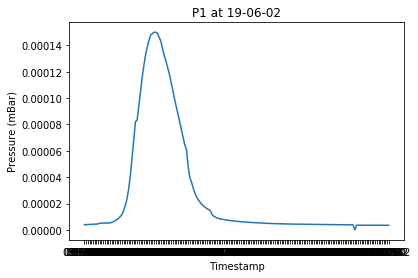

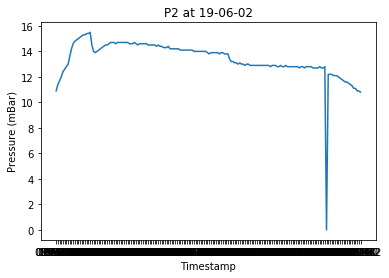

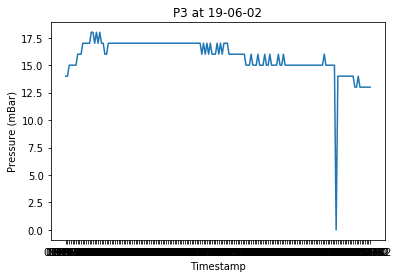

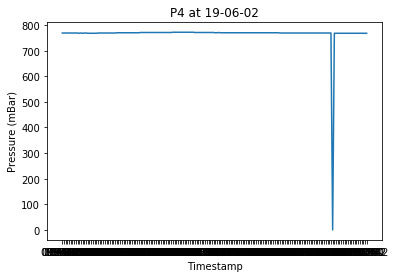

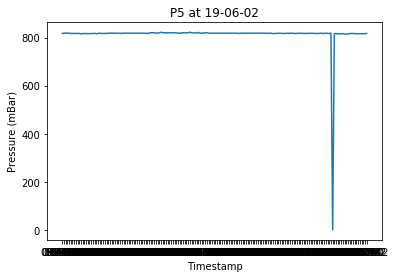

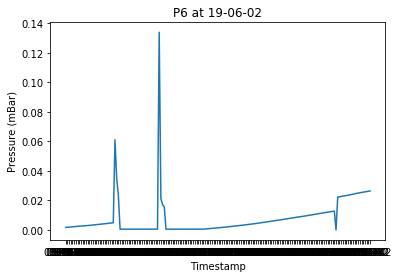

In [89]:
import csv
BF_PC_PATH = '\\\\MININT-ETA6HHA\\Desktop\\BF Log Files\\' 

#code to get the timestamp copied here from the thermometer class

logfile_name = 'maxigauge'
days_in_the_past = 0
ts = datetime.datetime.today() - datetime.timedelta(days=days_in_the_past)
#s = '%02d-%02d-%02d'%(ts.year-2000, ts.month, ts.day) 

pth = BF_PC_PATH + ds + '\\' + logfile_name+ ' ' + ds+'.log'

file_list = []
with open(pth) as csvFile:
    reader = csv.reader(csvFile)
    for row in reader:
        #print(row)
        file_list.append(row)
csvFile.close()

#
print(file_list[0])
times = [file_list[i][1] for i in range(len(file_list))]
Ps = []
for k in range(0,6):
    Ps.append(np.array([float(file_list[i][5+k*6]) for i in range(len(file_list))]))

i_start = 580
i_stop = -1
for k in range(len(Ps)):
    plt.figure()
    plt.plot(times[i_start:i_stop], Ps[k][i_start:i_stop])
    plt.ylabel('Pressure (mBar)')
    plt.xlabel('Timestamp')
    plt.title('P%d at ' % (k+1) + ds )
    

[  4.87851   4.87851   4.87851 ...,  10.2001   10.2001   10.2001 ]


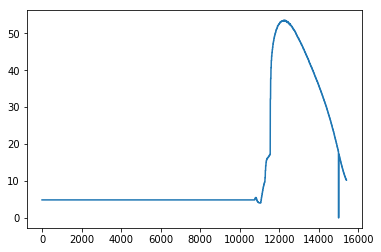

In [90]:
ts = datetime.datetime.today()
ds = '19-06-02'
logfile_name = 'CH6 T'
pth = BF_PC_PATH + ds + '\\' + logfile_name+ ' ' + ds+'.log'

time.sleep(0.1)
try:
    T = np.loadtxt(pth, usecols = (2), delimiter = ',')
except: # in the first few seconds of a day, a new log file hasn't been created
    ts = datetime.datetime.today() - datetime.timedelta(days=1) # use the last entry in the previous day
    ds = '%02d-%02d-%02d'%(ts.year-2000, ts.month, ts.day)
    pth = pth + ds + '\\CH9 T '+ds+'.log'
    T = np.loadtxt(pth, usecols = (2), delimiter = ',')[-1]
print(T)

plt.plot(T)

## Thermometer using BF logs

In [9]:
#set the path here of the shared desktop file
from pytopo.sweep import sweep, measure, nest, chain, szip, getter, setter, time_trace, do_experiment
from pytopo.qctools.instruments import create_inst

class Thermometer(Instrument):
    
    def __init__(self, name, logfile_path, **kw):
        super().__init__(name, **kw)        
        self.add_parameter('temperature', get_cmd=self._get_temperature, set_cmd=None, unit='K')
        
        self.add_parameter('counter', get_cmd=self._counter, set_cmd=None, unit='')
        self._ind = 0
        print('Path of network drive(set this manually dear USER): ', logfile_path)
        self.logfile_path = logfile_path
        
    def _counter(self):
        self._ind += 1
        return self._ind
    def _get_temperature(self):
        ts = datetime.datetime.today()
        ds = '%02d-%02d-%02d'%(ts.year-2000, ts.month, ts.day)
        pth = self.logfile_path + ds + '\\CH9 T '+ds+'.log'
        time.sleep(0.1)
        try:
            T = np.loadtxt(pth, usecols = (2), delimiter = ',')[-1]
        except: # in the first few seconds of a day, a new log file hasn't been created
            ts = datetime.datetime.today() - datetime.timedelta(days=1) # use the last entry in the previous day
            ds = '%02d-%02d-%02d'%(ts.year-2000, ts.month, ts.day)
            pth = self.logfile_path + ds + '\\CH9 T '+ds+'.log'
            T = np.loadtxt(pth, usecols = (2), delimiter = ',')[-1]
        return T
    
        
    
T_probe = create_inst(Thermometer, 'T_probe', logfile_path=BF_PC_PATH, force_new_instance=True)
T_probe.temperature()



Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


0.0741869

In [9]:
BF_PC_PATH = '\\\\MININT-ETA6HHA\\Desktop\\BF Log Files\\'
ds = '%02d-%02d-%02d'%(ts.year-2000, ts.month, ts.day)
pth = BF_PC_PATH+ ds + '\\CH9 T '+ds+'.log'

In [10]:
vna.add_channel('S12')

NameError: name 'vna' is not defined

# VNA measurements of lines.
https://github.com/QCoDeS/Qcodes/blob/master/docs/examples/driver_examples/Qcodes%20example%20with%20Rohde%20Schwarz%20ZNB.ipynb 

In [11]:
vna = create_inst(ZNB.ZNB, "VNA", 'USB0::0x0AAD::0x01A1::101879::INSTR', force_new_instance=True, init_s_params=False)
#station.remove_component(vna)
station.add_component(vna)
# the channel we want to measure. we set init_s_params false to not have to measure all channels, thus saving time 
channel_name = 'S21' ##Now we add a channel S12: Since the HEMT is connected to port 1. 
vna.add_channel(channel_name)


Connected to: Rohde-Schwarz ZNB20-2Port (serial:1311601062101879, firmware:2.86) in 0.06s


In [12]:
vna.rf_off()

In [146]:
vna = create_inst(ZNB.ZNB, "VNA", 'USB0::0x0AAD::0x01A1::101879::INSTR', force_new_instance=True)

Instrument VNA already exists.
Connected to: Rohde-Schwarz ZNB20-2Port (serial:1311601062101879, firmware:2.86) in 0.23s


In [12]:
vna.rf_off()
station = qc.Station(vna)

To use the VNA we likely want to turn on RF Power, which is off by default for safty in this driver. The driver default to low power but for safety lets set it to -50 dBm. The rf can be turned on and off globally and the power adjusted individually for each channel

In [ ]:
vna.channels.autoscale()
vna.channels.power(-40)

In [ ]:
#vna.channels.power(-50)
#vna.rf_off()
vna.channels.autoscale()

In [ ]:
station = qc.Station(vna)

In [13]:
import time
import numpy as np
def do_single_sweep(n_pts = 10000, f_start = 3.2e9, f_stop = 6.5e9, power=-60, n_avg=10, channel_name='S12'):

    # let's set the trace properties. 
    trace = getattr(vna.channels, channel_name)
    trace.avg(n_avg)
    trace.npts(n_pts)
    trace.power(power)
    trace.start(f_start)
    trace.stop(f_stop)
    vna.rf_on()
    
    
    #now setup the qcodes measurement object
    meas = Measurement()
    #meas.register_parameter(temperature, setpoints=['time',])
    #meas.register_parameter(temperature_sample, setpoints=['time',])
    meas.register_custom_parameter('frequency', unit='Hz',
                                   paramtype='array')
    meas.register_custom_parameter('time', unit='s', paramtype='numeric')
    meas.register_custom_parameter('power', unit='dBm', setpoints=['time'])
    meas.register_custom_parameter('magnitude_dB', unit='dB', 
                                    setpoints=['frequency'],
                                   paramtype='array'),
    meas.register_custom_parameter('magnitude_raw', unit='V', 
                                   setpoints=['frequency'],
                                   paramtype='array')
    meas.register_custom_parameter('phase', unit='rad', 
                                   setpoints=[ 'frequency'],
                                   paramtype='array')
    
    with meas.run() as datasaver:
        fvals = np.linspace(trace.start(), trace.stop(), trace.npts())
        mag, phase = trace.trace_mag_phase()
        mag_db = 20*np.log10(mag) #convert to dB
        result = [ ('time', time.time()),
           # (temperature, temperature()),
           # (temperature_sample, temperature_sample()),
            ('frequency', fvals),
            ('magnitude_raw', mag),
            ('magnitude_dB',mag_db ),
            ('phase', phase),
            ('power', power)]
        datasaver.add_result(
            *result
           )
    return datasaver.run_id


def do_single_sweep_with_temperature(n_pts = 10000, f_start = 3.2e9, f_stop = 6.5e9, power=-60, n_avg=10, channel_name='S12'):

    """
    Saves a timestamp and a temperature. 
    """
    #first try to get temperature:
    T_probe = create_inst(Thermometer, 'T_probe', logfile_path=BF_PC_PATH, force_new_instance=True)
    temperature = T_probe.temperature()
    
    # let's set the trace properties. 
    trace = getattr(vna.channels, channel_name)
    trace.avg(n_avg)
    trace.npts(n_pts)
    trace.power(power)
    trace.start(f_start)
    trace.stop(f_stop)
    vna.rf_on()
    
    #now setup the qcodes measurement object
    meas = Measurement()
    #meas.register_parameter(temperature, setpoints=['time',])
    #meas.register_parameter(temperature_sample, setpoints=['time',])
    meas.register_custom_parameter('frequency', unit='Hz',
                                   paramtype='array')
    meas.register_custom_parameter('time', unit='s', paramtype='numeric')
    meas.register_custom_parameter('temperature', unit='K', paramtype='numeric', setpoints=['time'])
    meas.register_custom_parameter('power', unit='dBm', setpoints=['time'])
    meas.register_custom_parameter('magnitude_dB', unit='dB', 
                                    setpoints=['frequency'],
                                   paramtype='array'),
    meas.register_custom_parameter('magnitude_raw', unit='V', 
                                   setpoints=['frequency'],
                                   paramtype='array')
    meas.register_custom_parameter('phase', unit='rad', 
                                   setpoints=[ 'frequency'],
                                   paramtype='array')
    
    with meas.run() as datasaver:
        fvals = np.linspace(trace.start(), trace.stop(), trace.npts())
        mag, phase = trace.trace_mag_phase()
        mag_db = 20*np.log10(mag) #convert to dB
        result = [ ('time', time.time()),
           # (temperature, temperature()),
           # (temperature_sample, temperature_sample()),
            ('frequency', fvals),
            ('magnitude_raw', mag),
            ('magnitude_dB',mag_db ),
            ('phase', phase),
            ('power', power),
            ('temperature', temperature)]
        datasaver.add_result(
            *result
           )
    return datasaver.run_id

In [ ]:
power_levels = list(range(5,15,5))
res_freqs = [3.535e9, 4.020e9, 4.847e9, 5.889e9]
df = 0.1e9

for power in power_levels:   
    for freq in res_freqs:
        print(freq-df)
        print(freq+df)
        print(power)
        run_id = do_single_sweep_with_temperature(n_pts = 30000, f_start = freq-df, f_stop = freq+df,
                                                  power=power, n_avg=30, channel_name=channel_name)
        
        
        


In [49]:
vna.rf_off()

In [55]:
run_id = do_single_sweep_with_temperature(n_pts = 20000, f_start = 2e9, f_stop = 13.5e9,
                                                  power=10, n_avg=20, channel_name=channel_name)

Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
Starting experimental run with id: 8


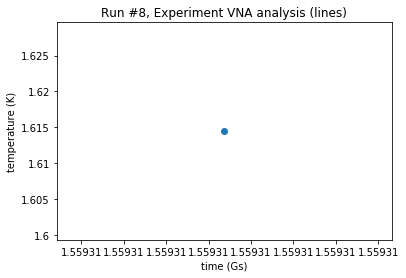

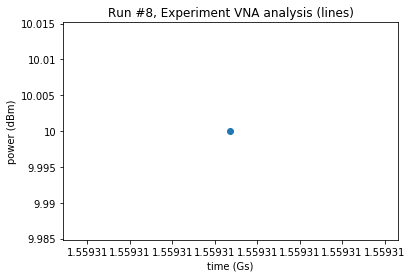

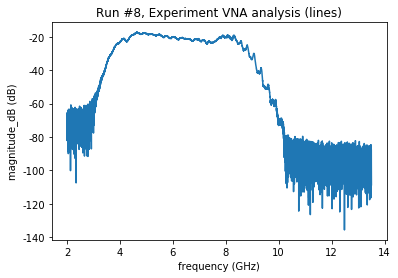

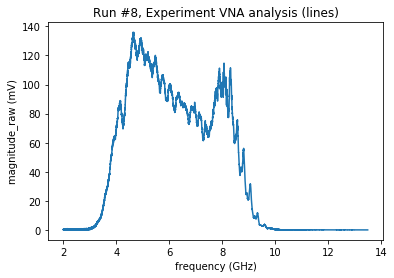

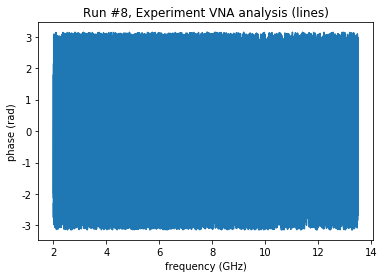

In [56]:
aves, bla = plot_by_id(run_id)

In [57]:
dat = load_by_id(run_id)

Text(0,0.5,'Magnitude (dB)')

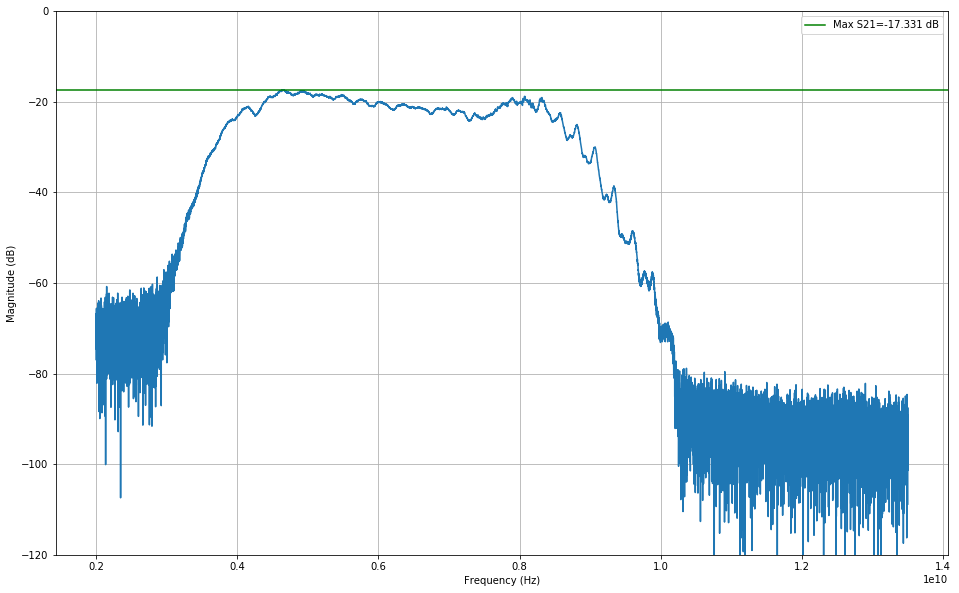

In [59]:
freqs = np.squeeze(dat.get_data('frequency'))
mag_db = np.squeeze(dat.get_data('magnitude_dB'))

plt.figure(figsize=(16,10))
plt.plot(freqs,mag_db)
plt.grid()
plt.ylim(-120,-0)
plt.axhline(y = np.max(mag_db), label='Max S21=%.3f dB' % np.max(mag_db), color='g')
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
#plt.xlim(4e9,8e9)

In [ ]:
meas = Measurement()
vna.channels.S12.format('dB')
meas.register_parameter(vna.channels.S12.trace)
with meas.run() as datasaver:
    get_v = vna.channels.S12.trace.get()
    datasaver.add_result((vna.channels.S12.trace, get_v))
ax, cbax = plot_by_id(datasaver.run_id)

In [60]:
vna.rf_off()

## 2 D sweeps: power 

In [15]:
def do_2d_power_sweep(powers=[],n_pts = 10000, f_start = 3.2e9, f_stop = 6.5e9, n_avg=10, channel_name='S12'):

    """
. 
    """
    #first try to get temperature:
    T_probe = create_inst(Thermometer, 'T_probe', logfile_path=BF_PC_PATH, force_new_instance=True)
    temperature = T_probe.temperature()
    
    # let's set the trace properties. 
    channel = getattr(vna.channels, channel_name)
    
    channel.avg(n_avg)
    channel.npts(n_pts)
    channel.start(f_start)
    channel.stop(f_stop)
    channel.power(powers[0])
    channel.format('Complex')
    vna.rf_on()
    
    #now setup the qcodes measurement object
    meas = Measurement()
    meas.register_custom_parameter('temperature', unit='K', paramtype='numeric')
    #meas.register_parameter(temperature_sample, setpoints=['time',])
    meas.register_custom_parameter('frequency', unit='Hz',
                                   paramtype='array')
    meas.register_custom_parameter('power', unit='dBm'),
    meas.register_custom_parameter('Re_S', unit='V', 
                                    setpoints=['frequency','power'],
                                   paramtype='array'),
    meas.register_custom_parameter('Im_S', unit='V', 
                                   setpoints=['frequency', 'power'],
                                   paramtype='array')
    meas.register_custom_parameter('magnitude_dB', unit='dB', 
                                   setpoints=[ 'frequency', 'power'],
                                   paramtype='array')
    
    with meas.run() as datasaver:
        for power in powers:
            channel.power(power)
            fvals = np.linspace(channel.start(), channel.stop(), channel.npts())
            S12 = channel.trace.get()
            mag_db = 20*np.log10(np.abs(S12)) #convert to dB
            result = [ 
                ('frequency', fvals),
                ('Re_S', np.real(S12)),
                ('magnitude_dB',mag_db ),
                ('Im_S', np.imag(S12)),
                ('power', power),
                ('temperature', temperature)]
            datasaver.add_result(
                *result
               )
            print('done power %d' % power)
    return datasaver.run_id




In [ ]:
np.arange(-30,16, 1)

In [109]:
res_freqs = [3.535e9, 4.020e9, 4.847e9, 5.889e9]
df = 0.02e9
  
for freq in res_freqs:
    print(freq-df)
    print(freq+df)
    run_id_1 = do_2d_power_sweep(powers=np.arange(-20,15, 5),n_pts = 2000, f_start = freq-df, f_stop = freq+df, n_avg=500, channel_name='S12')
vna.rf_off()

3515000000.0
3555000000.0
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
Starting experimental run with id: 52


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -20


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -15


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -10


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -5


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power 0


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power 5


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power 10
4000000000.0
4040000000.0
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
Starting experimental run with id: 53


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -20


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -15


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -10


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -5


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power 0


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power 5


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power 10
4827000000.0
4867000000.0
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
Starting experimental run with id: 54


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -20


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -15


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -10


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -5


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power 0


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power 5


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power 10
5869000000.0
5909000000.0
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
Starting experimental run with id: 55


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -20


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -15


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -10


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -5


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power 0


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power 5


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power 10


In [ ]:
data = load_by_id(23)
freqs = np.squeeze(np.array(data.get_data('frequency')))
powers = np.squeeze(np.array(data.get_data('power')))
mag = np.squeeze(np.array(data.get_data('magnitude_dB')))
plt.figure()
plt.plot(freqs.T,mag.T, 'x')

In [105]:
vna.rf_off()

In [108]:
do_2d_power_sweep(powers=np.arange(-40,0, 5),n_pts = 30000, f_start = 2.9e9, f_stop = 12e9, n_avg=50, channel_name='S12')

Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
Starting experimental run with id: 51


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -40


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -35


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -30


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -25


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -20


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -15


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -10


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -5


51

## Temperature sweep

In [145]:
def do_2d_T_sweep(T_max = 20, power = -20,n_pts = 10000, f_start = 3.2e9, f_stop = 6.5e9, n_avg=10, channel_name='S12'):

    """
. 
    """

    # let's set the trace properties. 
    channel = getattr(vna.channels, channel_name)
    
    channel.avg(n_avg)
    channel.npts(n_pts)
    channel.start(f_start)
    channel.stop(f_stop)
    channel.power(power)
    channel.format('Complex')
    vna.rf_on()
    
    #now setup the qcodes measurement object
    meas = Measurement()
    meas.register_custom_parameter('temperature', unit='K', paramtype='numeric')
    #meas.register_parameter(temperature_sample, setpoints=['time',])
    meas.register_custom_parameter('frequency', unit='Hz',
                                   paramtype='array')
    meas.register_custom_parameter('power', unit='dBm'),
    meas.register_custom_parameter('Re_S', unit='V', 
                                    setpoints=['frequency','temperature'],
                                   paramtype='array'),
    meas.register_custom_parameter('Im_S', unit='V', 
                                   setpoints=['frequency', 'temperature'],
                                   paramtype='array')
    meas.register_custom_parameter('magnitude_dB', unit='dB', 
                                   setpoints=[ 'frequency', 'temperature'],
                                   paramtype='array')
    
    with meas.run() as datasaver:
      #first try to get temperature:
        T_probe = create_inst(Thermometer, 'T_probe', logfile_path=BF_PC_PATH, force_new_instance=True)
        temperature = T_probe.temperature()
        while temperature <  T_max:
            T_probe = create_inst(Thermometer, 'T_probe', logfile_path=BF_PC_PATH, force_new_instance=True)
            temperature = T_probe.temperature()
            
            fvals = np.linspace(channel.start(), channel.stop(), channel.npts())
            S12 = channel.trace.get()
            mag_db = 20*np.log10(np.abs(S12)) #convert to dB
            result = [ 
                ('frequency', fvals),
                ('Re_S', np.real(S12)),
                ('magnitude_dB',mag_db ),
                ('Im_S', np.imag(S12)),
                ('power', power),
                ('temperature', temperature)]
            datasaver.add_result(
                *result
               )
            print('done T=%.3f' % temperature)
    return datasaver.run_id




In [159]:
do_2d_T_sweep(power=20,T_max=20, n_pts = 5000, f_start = 2.5e9, f_stop = 10e9, n_avg=5, channel_name='S12')

Starting experimental run with id: 92
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=12.005
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=12.003
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=12.028
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=12.013
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=12.016
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=12.041
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=12.034
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=12.054
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=12.079
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=12.089
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=12.106
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=12.108
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=12.111
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=12.113
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=12.113
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=12.144
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=12.151
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=12.150
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=12.153
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=12.152
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=12.150
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=12.180
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=12.191
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=12.196
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=12.216
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=12.202
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=12.200
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=12.227
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=12.225
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=12.232
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=12.237
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=12.247
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=12.253
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=12.289
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=12.289
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=12.285
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=12.296
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=12.304
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=12.287
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=12.298
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=12.311
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=12.329
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=12.329
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=12.316
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=12.317
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=12.327
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=12.324
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=12.310
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=12.309
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=12.302
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=12.296
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=12.278
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=12.262
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=12.249
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=12.226
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=12.215
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=12.205
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=12.199
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=12.198
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=12.159
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=12.117
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=12.088
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=12.083
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=12.048
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=12.027
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=12.020
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=11.980
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=11.932
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=11.914
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=11.873
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=11.836
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=11.799
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=11.770
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=11.733
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=11.707
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=11.686
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=11.655
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=11.601
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=11.583
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=11.564
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=11.525
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=11.451
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=11.416
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=11.389
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=11.349
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=11.320
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=11.290
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=11.244
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=11.221
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=11.186
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=11.164
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=11.119
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=11.084
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=11.033
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=11.010
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=10.964
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=10.942
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=10.912
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=10.889
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=10.799
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=10.790
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=10.759
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=10.715
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=10.699
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=10.669
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=10.593
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=10.576
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=10.556
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=10.524
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=10.478
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=10.450
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=10.393
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=10.385
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=10.353
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=10.331
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=10.286
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=10.266
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=10.217
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=10.197
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=10.181
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=10.134
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=10.097
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=10.083
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=10.036
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=10.005
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=9.960
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=9.946
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=9.925
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=9.903
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=9.842
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=9.807
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=9.797
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=9.775
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=9.760
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=9.745
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=9.687
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=9.647
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=9.618
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=9.617
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=9.584
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=9.563
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=9.538
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=9.493
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=9.462
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=9.437
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=9.429
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=9.413
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=9.385
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=9.347
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=9.330
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=9.303
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=9.271
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=9.256
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=9.225
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=9.184
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=9.153
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=9.127
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=9.110
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=9.083
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=9.061
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=9.016
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=8.984
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=8.981
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=8.968
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=8.946
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=8.919
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=8.877
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=8.860
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=8.844
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=8.820
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=8.807
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=8.779
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=8.722
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=8.706
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=8.695
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=8.685
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=8.668
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=8.635
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=8.587
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=8.562
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=8.547
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=8.532
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=8.505
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=8.491
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=8.441
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=8.423
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=8.406
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=8.394
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=8.369
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=8.348
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=8.298
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=8.271
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=8.260
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=8.230
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=8.210
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=8.199
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=8.153
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=8.132
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=8.116
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=8.101
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=8.078
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=8.060
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=8.041
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=8.003
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=7.992
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=7.979
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=7.946
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=7.913
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=7.891
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=7.864
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=7.847
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=7.820
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=7.800
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=7.778
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=7.761
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=7.734
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=7.699
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=7.682
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=7.666
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=7.649
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=7.628
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=7.589
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=7.559
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=7.544
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=7.531
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=7.512
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=7.478
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=7.451
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=7.436
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=7.427
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=7.407
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=7.381
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=7.354
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=7.311
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=7.303
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=7.290
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=7.279
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=7.260
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=7.240
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=7.218
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=7.180
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=7.162
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=7.142
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=7.117
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=7.101
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=7.088
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=7.045
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=7.037
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=7.018
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=6.989
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=6.975
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=6.960
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=6.924
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=6.916
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=6.892
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=6.877
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=6.857
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=6.833
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=6.806
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=6.793
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=6.779
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=6.765
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=6.745
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=6.728
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=6.703
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=6.680
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=6.663
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=6.647
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=6.624
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=6.605
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=6.572
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=6.555
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=6.541
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=6.533
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=6.521
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=6.498
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=6.486
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=6.454
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=6.440
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=6.425
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=6.412
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=6.395
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=6.367
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=6.335
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=6.331
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=6.316
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=6.299
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=6.282
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=6.269
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=6.244
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=6.231
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=6.227
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=6.206
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=6.181
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=6.164
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=6.143
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=6.127
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=6.119
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=6.105
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=6.078
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=6.064
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=6.041
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=6.025
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=6.014
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.996
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.982
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.973
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.953
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.931
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.922
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.898
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.886
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.875
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.851
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.836
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.825
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.817
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.811
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.797
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.782
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.756
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.748
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.731
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.715
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.708
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.694
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.669
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.662
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.656
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.637
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.610
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.598
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.579
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.574
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.566
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.554
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.540
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.529
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.517
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.499
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.495
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.483
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.470
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.459
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.437
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.428
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.418
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.405
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.392
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.383
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.382
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.356
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.346
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.333
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.322
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.312
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.310
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.288
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.276
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.271
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.253
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.239
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.242
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.224
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.211
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.203
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.195
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.182
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.175
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.156
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.148
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.141
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.134
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.120
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.114
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.105
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.095
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.087
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.074
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.064
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.055
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.051
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.037
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.028
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.029
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.023
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.013
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=5.001
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.985
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.978
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.973
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.968
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.960
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.951
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.938
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.926
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.923
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.919
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.912
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.906
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.891
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.887
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.875
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.867
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.867
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.865
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.853
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.843
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.836
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.837
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.832
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.819
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.808
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.811
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.801
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.796
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.790
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.777
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.772
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.766
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.762
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.757
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.751
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.743
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.738
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.731
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.725
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.720
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.718
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.713
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.708
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.695
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.690
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.677
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.670
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.668
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.667
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.658
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.655
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.652
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.652
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.647
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.637
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.628
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.624
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.622
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.621
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.610
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.605
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.609
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.603
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.590
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.577
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.576
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.576
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.581
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.574
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.562
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.558
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.565
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.559
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.549
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.544
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.541
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.539
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.532
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.526
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.524
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.511
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.514
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.517
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.511
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.500
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.504
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.499
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.493
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.490
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.490
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.486
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.479
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.476
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.478
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.472
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.473
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.476
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.472
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.463
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.454
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.455
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.453
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.454
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.449
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.444
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.440
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.439
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.433
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.434
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.432
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.425
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.411
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.412
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.420
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.419
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.417
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.406
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.411
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.413
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.410
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.406
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.405
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.403
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.395
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.392
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.391
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.389
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.388
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.384
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.376
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.374
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.376
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.383
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.387
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.381
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.372
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.367
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.371
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.367
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.368
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.364
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.360
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.353
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.349
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.351
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.352
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.349
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.346
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.350
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.343
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.335
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.339
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.339
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.335
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.333
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.328
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.339
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.340
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.335
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.332
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.331
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.327
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.327
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.323
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.325
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.328
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.321
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.320
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.320
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.319
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.315
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.318
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.319
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.315
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.311
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.308
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.306
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.303
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.302
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.305
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.299
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.296
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.293
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.300
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.295
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.291
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.292
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.294
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.292
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.286
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.286
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.285
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.280
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.277
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.278
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.282
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.282
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.278
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.275
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.271
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.273
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.273
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.273
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.273
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.269
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.265
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.261
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.262
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.267
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.266
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.262
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.265
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.258
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.255
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.256
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.257
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.252
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.250
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.249
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.247
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.246
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.243
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.245
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.247
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.246
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.247
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.239
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.243
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.246
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.244
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.237
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.241
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.241
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.235
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.232
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.242
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.233
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.231
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.231
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.232
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.234
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.224
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.228
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.226
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.224
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.224
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.228
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.223
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.223
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.227
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.231
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.229
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.225
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.224
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.215
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.219
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.221
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.224
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.218
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.211
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.205
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.207
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.206
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.208
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.211
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.208
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.204
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.201
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.205
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.201
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.202
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.203
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.201
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.199
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.201
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.200
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.202
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.201
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.200
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.201
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.197
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.192
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.194
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.199
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.195
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.191
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.184
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.187
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.196
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.200
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.194
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.192
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.193
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.186
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.181
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.180
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.179
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.185
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.184
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.177
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.177
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.180
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.182
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.181
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.177
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.178
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.182
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.177
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.173
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.173
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.175
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.171
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.169
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.166
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.169
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.174
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.170
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.165
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.167
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.168
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.169
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.165
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.166
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.168
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.165
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.166
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.166
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.165
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.162
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.159
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.157
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.157
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.156
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.157
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.159
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.156
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.158
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.153
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.156
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.157
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.154
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.151
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.150
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.152
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.151
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.150
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.146
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.144
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.146
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.151
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.152
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.148
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.143
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.139
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.140
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.141
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.140
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.134
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.136
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.136
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.135
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.137
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.141
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.135
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.133
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.131
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.131
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.132
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.134
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.136
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.134
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.131
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.132
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.134
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.128
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.125
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.123
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.127
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.129
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.127
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.122
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.117
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.121
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.120
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.118
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.124
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.127
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.123
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.119
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.120
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.118
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.121
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.121
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.118
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.119
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.117
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.117
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.116
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.116
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.117
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.114
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.113
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.106
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.107
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.107
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.110
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.114
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.107
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.115
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.114
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.110
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.110
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.109
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.105
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.107
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.103
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.104
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.102
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.105
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.105
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.101
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.104
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.107
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.106
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.104
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.100
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.098
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.097
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.098
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.096
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.095
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.097
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.099
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.096
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.093
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.091
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.091
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.096
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.100
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.097
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.094
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.097
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.094
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.090
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.092
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.094
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.084
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.086
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.089
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.088
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.091
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.094
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.089
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.087
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.088
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.091
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.087
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.083
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.081
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.083
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.083
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.079
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.076
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.078
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.078
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.078
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.077
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.079
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.079
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.081
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.079
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.077
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.074
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.077
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.078
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.071
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.071
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.074
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.075
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.078
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.076
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.074
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.074
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.071
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.065
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.065
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.067
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.068
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.069
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.068
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.068
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.070
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.063
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.064
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.064
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.060
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.062
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.064
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.065
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.059
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.059
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.062
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.061
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.063
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.062
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.059
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.057
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.056
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.057
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.060
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.059
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.059
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.053
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.050
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.051
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.053
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.060
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.053
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.052
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.051
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.048
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.051
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.058
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.055
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.044
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.045
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.044
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.047
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.053
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.048
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.045
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.045
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.041
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.050
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.056
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.057
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.047
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.049
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.048
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.044
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.046
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.043
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.038
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.040
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.043
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.045
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.048
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.043
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.039
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.040
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.038
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.036
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.035
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.038
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.041
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.035
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.032
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.039
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.042
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.040
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.035
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.035
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.035
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.036
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.038
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.038
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.039
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.035
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.032
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.028
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.028
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.029
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.030
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.026
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.026
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.028
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.033
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.030
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.027
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.024
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.027
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.031
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.030
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.025
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.029
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.027
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.027
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.026
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.023
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.019
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.019
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.017
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.016
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.018
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.021
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.020
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.019
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.017
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.020
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.015
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.016
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.021
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.017
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.013
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.007
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.011
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.012
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.011
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.013
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.014
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.005
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.006
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.008
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.008
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.005
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.000
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.004
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.999
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.001
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.003
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.007
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.005
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.006
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.998
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.999
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.001
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.000
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.000
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.999
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.999
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.999
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.002
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.005
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.001
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.999
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.998
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.001
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.999
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.996
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=4.001
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.999
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.994
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.994
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.994
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.988
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.989
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.988
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.990
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.990
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.990
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.992
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.990
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.988
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.990
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.990
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.987
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.988
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.986
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.985
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.983
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.988
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.986
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.980
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.981
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.985
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.980
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.978
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.980
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.980
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.979
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.982
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.978
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.981
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.979
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.975
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.972
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.977
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.975
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.973
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.970
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.973
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.973
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.982
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.971
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.971
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.977
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.971
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.971
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.971
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.977
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.971
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.970
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.974
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.977
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.971
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.967
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.974
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.976
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.970
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.966
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.962
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.967
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.967
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.967
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.968
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.966
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.966
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.971
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.973
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.969
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.967
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.964
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.968
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.969
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.967
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.974
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.970
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.964
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.965
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.965
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.961
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.962
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.964
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.960
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.960
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.965
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.963
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.962
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.966
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.964
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.967
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.968
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.966
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.963
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.962
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.963
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.965
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.963
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.958
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.960
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.954
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.954
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.958
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.959
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.956
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.954
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.952
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.954
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.958
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.957
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.955
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.954
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.953
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.951
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.952
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.955
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.958
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.954
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.955
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.955
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.953
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.955
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.958
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.956
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.951
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.949
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.950
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.951
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.949
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.952
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.950
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.950
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.947
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.947
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.952
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.946
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.946
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.948
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.947
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.950
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.950
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.949
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.945
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.943
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.949
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.953
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.954
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.946
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.950
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.952
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.955
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.952
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.948
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.944
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.949
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.950
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.949
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.946
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.948
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.943
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.945
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.950
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.953
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.947
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.941
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.945
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.949
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.944
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.940
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.940
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.946
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.949
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.941
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.938
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.936
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.943
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.943
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.944
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.946
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.944
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.941
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.942
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.941
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.937
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.938
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.936
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.935
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.940
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.937
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.936
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.935
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.941
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.939
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.938
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.935
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.934
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.947
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.940
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.943
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.939
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.935
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.936
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.937
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.941
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.939
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.935
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.933
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.935
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.936
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.934
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.931
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.933
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.940
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.940
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.937
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.932
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.933
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.934
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.935
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.936
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.933
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.934
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.932
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.935
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.934
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.930
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.933
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.937
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.937
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.935
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.934
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.929
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.931
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.932
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.935
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.935
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.936
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.933
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.926
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.930
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.931
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.930
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.929
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.929
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.930
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.931
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.929
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.933
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.931
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.927
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.924
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.928
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.929
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.927
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.926
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.931
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.935
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.933
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.928
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.926
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.929
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.925
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.922
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.924
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.925
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.923
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.926
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.931
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.924
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.925
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.924
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.923
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.920
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.922
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.924
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.924
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.924
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.921
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.920
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.921
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.921
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.919
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.923
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.919
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.918
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.921
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.922
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.923
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.922
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.920
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.922
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.922
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.923
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.926
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.926
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.920
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.918
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.914
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.919
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.922
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.920
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.918
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.915
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.918
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.915
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.916
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.915
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.913
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.919
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.916
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.910
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.914
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.916
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.920
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.917
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.909
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.908
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.911
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.915
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.916
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.915
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.916
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.917
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.915
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.915
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.914
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.917
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.913
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.913
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.915
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.911
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.909
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.911
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.913
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.913
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.911
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.912
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.913
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.910
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.910
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.913
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.911
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.912
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.912
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.910
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.909
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.907
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.905
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.904
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.910
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.911
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.910
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.910
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.910
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.907
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.910
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.912
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.912
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.911
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.911
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.912
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.914
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.910
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.905
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.904
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.905
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.907
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.905
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.909
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.908
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.908
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.907
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.903
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.906
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.909
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.906
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.905
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.910
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.910
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.905
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.903
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.901
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.907
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.908
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.902
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.901
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.904
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.906
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.904
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.904
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.903
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.908
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.906
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.905
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.901
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.899
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.902
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.907
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.902
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.903
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.901
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.900
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.901
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.902
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.906
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.899
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.898
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.899
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.901
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.900
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.902
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.900
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.898
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.894
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.899
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.900
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.901
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.900
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.900
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.904
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.902
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.902
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.901
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.898
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.899
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.900
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.898
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.900
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.899
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.897
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.896
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.898
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.899
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.894
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.893
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.890
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.890
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.897
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.899
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.896
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.892
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.896
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.894
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.894
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.896
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.899
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.892
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.890
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.896
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.895
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.892
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.892
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.896
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.895
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.894
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.893
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.895
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.898
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.894
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.892
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.894
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.893
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.891
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.888
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.885
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.891
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.892
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.891
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.893
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.897
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.892
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.890
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.893
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.894
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.889
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.887
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.892
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.894
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.891
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.892
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.893
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.889
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.888
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.889
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.891
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.887
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.884
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.886
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.888
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.894
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.895
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.895
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.887
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.883
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.884
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.886
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.887
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.891
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.893
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.895
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.889
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.887
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.886
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.886
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.890
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.890
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.888
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.887
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.885
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.883
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.882
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.884
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.885
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.885
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.881
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.888
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.892
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.888
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.889
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.887
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.887
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.890
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.893
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.888
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.886
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.886
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.887
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.890
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.881
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.883
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.884
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.886
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.886
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.883
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.882
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.881
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.884
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.886
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.890
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.893
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.886
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.884
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.888
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.886
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.880
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.878
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.882
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.885
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.882
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.884
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.883
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.883
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.885
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.880
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.876
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.878
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.875
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.879
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.880
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.877
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.877
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.880
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.881
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.882
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.878
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.877
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.875
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.874
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.876
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.882
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.881
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.877
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done T=3.878
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


KeyboardInterrupt: 